<a href="https://colab.research.google.com/github/shuchangliang/german_credit_risk/blob/main/German_Credit_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




---


### **About Dataset**
The original dataset contains 1000 entries with 20 categorial/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. The link to the original dataset can be found below.



---


### **Content**
It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, I wrote a small Python script to convert it into a readable CSV file. Several columns are simply ignored, because in my opinion either they are not important or their descriptions are obscure. The selected attributes are:

- Age (numeric)
- Sex (text: male, female)
- Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - - skilled, 3 - highly skilled)
- Housing (text: own, rent, or free)
- Saving accounts (text - little, moderate, quite rich, rich)
- Checking account (numeric, in DM - Deutsch Mark)
- Credit amount (numeric, in DM)
- Duration (numeric, in month)
- Purpose (text: car, furniture/equipment, radio/TV, domestic appliances repairs, education, business, vacation/others)


---


### **Acknowledgements**
Source: https://archive.ics.uci.edu/dataset/144/statlog+german+credit+data


---


### **Contexts**
Through visual analysis, we conducted an initial exploration of the data and used cluster analysis to classify customers into different risk groups. Since the dataset lacked direct customer loan risk labels, we couldn't directly assess the accuracy of the risk classification. Therefore, we performed another round of cluster analysis (without considering customer loan risk characteristics) and divided the data into four categories. The classification results aligned with reality, allowing us to build a random forest model to identify key factors in risk classification. Although the model's accuracy cannot be precisely evaluated, it can still serve as an effective tool for preliminary risk assessment, thus improving the efficiency of risk identification.

## 1. **Libraries and Load Data**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data = pd.read_csv("german_credit_data.csv")
data.sample(5)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
417,417,23,female,2,rent,NaN,little,8471,18,education
129,129,29,female,2,own,little,little,3499,12,car
405,405,22,male,2,own,little,moderate,2039,24,radio/TV
568,568,41,male,2,own,NaN,moderate,3979,48,radio/TV
888,888,34,male,3,own,little,NaN,6614,36,car


## 2. **Data Preview and Pre-process**

### 2.1. **Data Preview**

In [3]:
data.shape

(1000, 10)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [10]:
# rename Unnamed: 0 to be Id, and change type to string
data = data.rename(columns={'Unnamed: 0': 'Id'})
data['Id'] = data['Id'].astype(str)

In [11]:
data.isna().sum()

,0
Id,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,0
Checking account,0
Credit amount,0
Duration,0
Purpose,0


In [6]:
data.duplicated().sum()

0

### 2.2. **Data Pre-process**

In [7]:
# Handle missing values ​​in Saving accounts and Checking accounts.
# Considering that missing values ​​account for a large proportion, it is not recommended to delete them directly.
# Similarly, it is not recommended to fill them with the mode, which may change the data situation. Here, fill them with unknown.

In [12]:
data['Saving accounts'].fillna('unknown', inplace=True)
data['Checking account'].fillna('unknown', inplace=True)
data.isna().sum()

,0
Id,0
Age,0
Sex,0
Job,0
Housing,0
Saving accounts,0
Checking account,0
Credit amount,0
Duration,0
Purpose,0


In [13]:
# View the unique values ​​of categorical features
characteristic = ['Sex','Job','Housing','Saving accounts','Checking account','Purpose']
for i in characteristic:
    print(f'{i}:')
    print(data[i].unique())
    print('-'*50)

Sex:
['male' 'female']
--------------------------------------------------
Job:
[2 1 3 0]
--------------------------------------------------
Housing:
['own' 'free' 'rent']
--------------------------------------------------
Saving accounts:
['unknown' 'little' 'quite rich' 'rich' 'moderate']
--------------------------------------------------
Checking account:
['little' 'moderate' 'unknown' 'rich']
--------------------------------------------------
Purpose:
['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']
--------------------------------------------------


## 3. **Data Explore**

### 3.1 **Analysis of basic customer situation**

<ipython-input-18-0877e0557727>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Age'], kde=True, bins=30, ax=axs[0, 0])
<ipython-input-18-0877e0557727>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sex', data=data, palette='Set2', ax=axs[0, 1])
<ipython-input-18-0877e0557727>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x

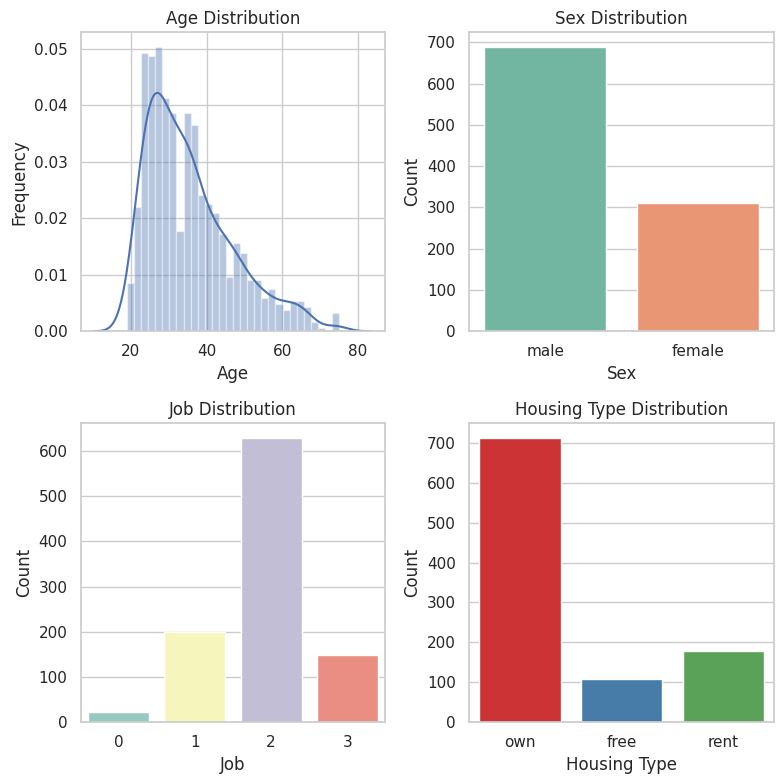

In [18]:
# Set drawing style
sns.set(style="whitegrid")
fig, axs = plt.subplots(2, 2, figsize=(8,8))

# Age distribution
sns.distplot(data['Age'], kde=True, bins=30, ax=axs[0, 0])
axs[0, 0].set_title('Age Distribution')
axs[0, 0].set_xlabel('Age')
axs[0, 0].set_ylabel('Frequency')

# Gender distribution
sns.countplot(x='Sex', data=data, palette='Set2', ax=axs[0, 1])
axs[0, 1].set_title('Sex Distribution')
axs[0, 1].set_xlabel('Sex')
axs[0, 1].set_ylabel('Count')

# Occupational skill distribution
sns.countplot(x='Job', data=data, palette='Set3', ax=axs[1, 0])
axs[1, 0].set_title('Job Distribution')
axs[1, 0].set_xlabel('Job')
axs[1, 0].set_ylabel('Count')

# Housing type distribution
sns.countplot(x='Housing', data=data, palette='Set1', ax=axs[1, 1])
axs[1, 1].set_title('Housing Type Distribution')
axs[1, 1].set_xlabel('Housing Type')
axs[1, 1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**The following conclusions can be drawn from the above figure:**
1. The age of customers is mainly concentrated in the younger age group (~ 25 - 30), which may indicate that young people are more inclined to apply for loans.
2. The number of male customers is higher than the number of female customers.
3. The number of customers working at level 2 is the largest, and the number of customers working at level 0 is the smallest, which may be because level 0 is unskilled and non-resident, and banks do not provide loans.
4. The number of customers with self-owned properties > the number of customers renting houses > the number of customers exempt from rent. Here, customers exempt from rent refer to those who live in residences that do not need to pay rent, such as free accommodation provided by the government or in the homes of relatives and friends.

### 3.2 **Customer economic situation analysis**

<ipython-input-19-d8b5d82cf734>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Saving accounts', data=data, order=order_savings, palette='Set2', ax=axs[0])
<ipython-input-19-d8b5d82cf734>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Checking account', data=data, order=order_checking, palette='Set3', ax=axs[1])


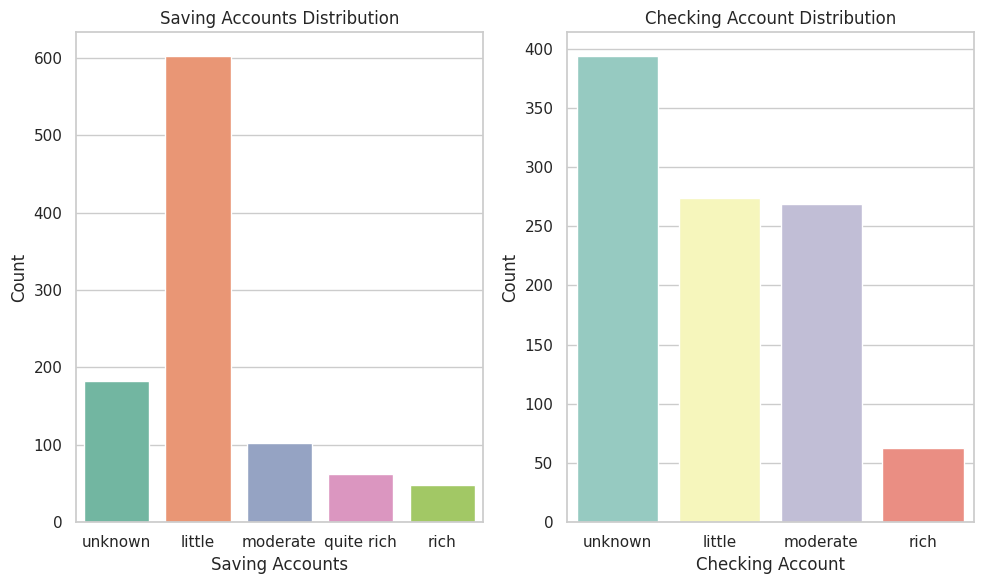

In [19]:
order_savings = ['unknown', 'little', 'moderate', 'quite rich', 'rich']
order_checking = ['unknown', 'little', 'moderate', 'rich']

fig, axs = plt.subplots(1, 2, figsize=(10,6))

# Savings account status distribution
sns.countplot(x='Saving accounts', data=data, order=order_savings, palette='Set2', ax=axs[0])
axs[0].set_title('Saving Accounts Distribution')
axs[0].set_xlabel('Saving Accounts')
axs[0].set_ylabel('Count')

# Checking account status distribution
sns.countplot(x='Checking account', data=data, order=order_checking, palette='Set3', ax=axs[1])
axs[1].set_title('Checking Account Distribution')
axs[1].set_xlabel('Checking Account')
axs[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

**From the above figure, we can know:**
1. The richer the customer, the less likely they are to choose a loan.
2. The customers with a small savings account have the most loans.
3. The number of customers with unknown, small, and medium checking account status is relatively large, especially the unknown customers, which indicates that the checking account may not be a major consideration when lending, which leads to the majority of unknown data.

### 3.3 **Customer loan situation analysis**

<ipython-input-21-fae62fa54fd2>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Credit amount'], kde=True, bins=30, ax=ax1)
<ipython-input-21-fae62fa54fd2>:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data['Duration'], kde=True, bins=20, color='green', ax=ax2)
<ipython-input-21-fae62

Text(0, 0.5, 'Purpose')

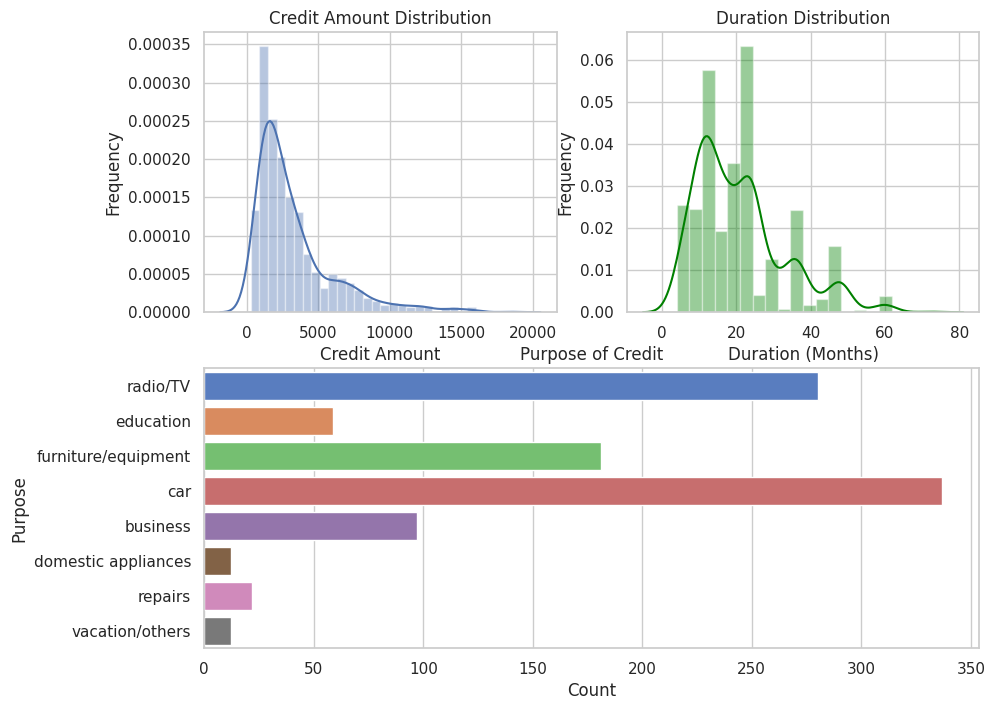

In [21]:
fig = plt.figure(figsize=(10,8))

# Create a 2x2 graph layout
ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 1, 2)

# Distribution of loan amount
sns.distplot(data['Credit amount'], kde=True, bins=30, ax=ax1)
ax1.set_title('Credit Amount Distribution')
ax1.set_xlabel('Credit Amount')
ax1.set_ylabel('Frequency')

# Distribution of loan term
sns.distplot(data['Duration'], kde=True, bins=20, color='green', ax=ax2)
ax2.set_title('Duration Distribution')
ax2.set_xlabel('Duration (Months)')
ax2.set_ylabel('Frequency')

# Distribution of loan purpose
sns.countplot(y='Purpose', data=data, palette='muted', ax=ax3)
ax3.set_title('Purpose of Credit')
ax3.set_xlabel('Count')
ax3.set_ylabel('Purpose')

**From the above chart, we can know that:**
1. Customers tend to apply for medium-to-low amount loans, and the loan period is mainly medium-to-short term.
2. Customers mainly use loans to buy cars, radios/TVs, and furniture/equipment.

## 4. **Customer loan risk assessment**

### 4.1 **Data Pre-process**

When performing **clustering** on data, it is essential to process both numerical and categorical features appropriately so that the clustering algorithm can treat them in a consistent and meaningful way. Here's **why encoding and normalizing are necessary:**
1. **Clustering algorithms such as k-means**, hierarchical clustering, or DBSCAN work with **numerical** data. Categorical variables (like Sex, Housing, Saving accounts, etc.) need to be transformed into a numerical format for these algorithms to understand and process the data effectively.
2. **Numerical** **features** (such as Age, Credit amount, Duration) **can vary significantly in scale**. For example, the Credit amount may range from hundreds to thousands, while Age may only range from 18 to 70. These differences in scale can distort clustering results, as **features with larger scales might dominate the calculation of distances between data points**.
**Why normalization is needed:**

* Equal scaling: Normalizing the numerical data brings all the features to a common scale, typically by subtracting the mean and dividing by the standard deviation (z-score normalization). This ensures that no single feature disproportionately influences the clustering process.
* Improves algorithm performance: Clustering algorithms like k-means rely on distance metrics (e.g., Euclidean distance). Without normalization, features with larger magnitudes can skew the distance calculations, leading to biased clustering results.


---



**In summary:**
1. Encoding categorical variables ensures that non-numerical data can be processed by clustering algorithms.
2. Normalizing numerical features ensures that all features contribute equally to the clustering process, regardless of their original scale.



In [22]:
# Select features
features = ['Age', 'Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Credit amount', 'Duration']
new_data = data[features].copy()

# Encode categorical features
new_data['Sex'] = new_data['Sex'].map({
    'female': 0,
    'male': 1})

new_data['Housing'] = new_data['Housing'].map({
    'free': 0,
    'rent': 1,
    'own': 2})

new_data['Saving accounts'] = new_data['Saving accounts'].map({
    'unknown': 0,
    'little': 1,
    'moderate': 2,
    'quite rich': 3,
    'rich': 4})

new_data['Checking account'] = new_data['Checking account'].map({
    'unknown': 0,
    'little': 1,
    'moderate': 2,
    'rich': 3})

# Normalize numerical features
scaler = StandardScaler()
num_features = ['Age', 'Credit amount', 'Duration']
new_data[num_features] = scaler.fit_transform(new_data[num_features])

new_data.sample(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration
395,-0.311879,1,2,1,2,2,3.008778,1.501479
204,0.215835,1,1,2,1,0,-0.629583,-0.738668
932,-0.487784,1,2,2,1,0,-0.725637,-0.987573
631,0.743550,1,2,2,1,1,-0.609025,-0.240857
344,0.127883,1,1,2,1,3,0.240221,-0.904604
634,-0.927547,0,1,2,1,2,-0.679205,0.256953
861,-0.663689,1,2,2,1,0,-0.390688,-0.240857
870,0.391740,0,2,2,3,0,1.561940,1.252574
125,-0.487784,1,2,2,1,1,-0.407701,-0.738668
398,0.919455,1,2,1,1,2,-0.725991,-0.738668
